<a href="https://colab.research.google.com/github/Jandsy/ml_finance_imperial/blob/main/Programming_Sessions/Programming_Session_6/Solution_Programming_Session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **<center>Machine Learning and Finance </center>**


## <center> Programming Session 7 - LSTM Based Classification Model Solution </center>



# LSTM Based Classificaiton Model

## Introduction
In this programming session, we are focusing on building an LSTM (Long Short-Term Memory) model aimed at the classification of news articles.

## Challenge
The core challenge is to develop a model capable of categorizing news texts into five predefined categories: tech, business, sport, entertainment, and politics.

## DataSet Overview
We are utilizing the BBC news articles (Source: [here](http://mlg.ucd.ie/files/publications/greene06icml.pdf)) dataset for this task. It comprises texts each labeled under one of the five categories mentioned.

## Objective
Our goal is to create and refine an LSTM-based machine learning model that efficiently classifies news articles into their respective categories based on their textual content.

In [ ]:
# Import basic libraries
import matplotlib.pyplot as plt # for plotting
import numpy as np # for manipulating arrays
import tensorflow as tf # for creating Neural Networks, we will use it to load data
import os
import pandas as pd
plt.style.use('dark_background') # to adapt the colors to a dark background
from IPython.display import Image # for showing graphs from the lectures

# 1. Preprocessing the Data

The goal of this part is to prepare our dataset into a format suitable for training by transforming it into a `(N, T)` tensor where:

- `N` represents the number of samples in our dataset.
- `T` denotes the uniform length of each sequence within the dataset.

### Preprocessing Steps

1. **Determine Sequence Length (`T`):** Select a fixed sequence length `T`, which serves as another hyperparameter in our model preparation.

2. **Sequence Adjustment:**
    - **Padding:** For sequences shorter than `T`, pad them with zeros to match the desired length.
    - **Truncation:** For sequences exceeding the length `T`, truncate them to maintain uniformity.


<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1GLwOZWrMiprZpN8jijTkLO_GVpgmi9MM"></center>

You can find the data in the following in github. The csv file is named `bbc-text.csv`

You will find the following columns:

* `text` contains the news.

* `category` is an element of the following categories:
  * tech
  * business
  * sport
  * entertainment
  * politics




---
<font color=green>Q1:</font>
<br><font color='green'>
Load the dataframe and call the dataframe `df` and store the elements in the column `text` in a list called `texts`
</font>

---

In [ ]:

# Load the dataframe
# Load the dataframe
df = pd.read_csv('https://raw.githubusercontent.com/Jandsy/ml_finance_imperial/refs/heads/main/Programming_Sessions/Programming_Session_6/bbc-text.csv')

In [ ]:
df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


The following function is used for cleaning the texts:

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean(texts):
  clean_texts = []
  for sequence in texts:
    # Get the tokens
    words = sequence.split()
    # Keep only the words
    alphabetic_only = [word for word in words if word.isalpha()]
    # All tokens should be written in lowercase
    lower_case_only = [word.lower() for word in alphabetic_only]
    # Select the stop words from nltk
    stopwords_nltk = set(stopwords.words('english'))
    # Delete the stop words
    cleaned_words = [word for word in lower_case_only if word not in stopwords_nltk]
    # Transform the list of tokens into a long string
    clean_sequence = ' '.join(cleaned_words)
    # Save the result in the list clean_texts
    clean_texts.append(clean_sequence)
  return clean_texts

---
<font color=green>Q2:</font>
<br><font color='green'>
Modify the `text` column by applying the `clean()` function on its contents. After processing, the updated texts should be stored back in the same `text` column.
</font>

---

In [ ]:
df["text"] = clean(df.text.values)

---
<font color=green>Q3:</font>
<br><font color='green'>
In the dataframe `df`, update the `category` column by substituting the existing category names with their corresponding indices from the provided table.
</font>

---




| **category**  | **index** |
|---------------|-----------|
| tech          | 0         |
| business      | 1         |
| sport         | 2         |
| entertainment | 3         |
| politics      | 4         |




In [ ]:
df['category'].replace({'tech':0, 'business':1, 'sport':2, 'entertainment':3, 'politics':4},
                       inplace=True)

<ipython-input-7-91a6652abcb2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category'].replace({'tech':0, 'business':1, 'sport':2, 'entertainment':3, 'politics':4},
<ipython-input-7-91a6652abcb2>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['category'].replace({'tech':0, 'business':1,

In [ ]:
df.category

,category
0,0
1,1
2,2
3,2
4,3
...,...
2220,1
2221,4
2222,3
2223,4


---
<font color=green>Q4:</font>
<br><font color='green'>
Define a list, called `labels` containing the targets associated with each text in the column `text`.
</font>

---

In [ ]:
labels = df["category"].values

---
<font color=green>Q5:</font>
<br><font color='green'>
Preprocess the texts in the column `text` and transform them into sequences of integers:

* Use `Tokenizer` from `tensorflow.keras.preprocessing.text` to create and fit a Tokenizer with the vocabulary size.
* Create your word_index dictionary and print the number of unique tokens found.
* Convert texts to sequences of integers.
</font>

---

In [ ]:
# Import Modules
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Set Hyperparameters: Vocabulary size
V = 10000

# Import Modules
from tensorflow.keras.preprocessing.text import Tokenizer

texts = df["text"].values

# Create the Tokenizer
tokenizer = Tokenizer(num_words=V) # Filter some elements + oov_token (TO DO)

# Fit the tokenizer on the texts to create the word_index dictionary
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


# From texts to sequences of integers
sequences = tokenizer.texts_to_sequences(texts)

Found 26149 unique tokens.


---
<font color=green>Q6:</font>
<br><font color='green'>
Utilize `pad_sequences` from `tensorflow.keras.preprocessing.sequence` to convert the list of sequences into an $(N, T)$ tensor, which should be named `data`. (Here, set `T` to 300.)
</font>

---

In [ ]:
# Set hyperparameters
T = 300

# Import Module
from tensorflow.keras.preprocessing.sequence import pad_sequences
data = pad_sequences(sequences, maxlen= T)

---
<font color=green>Q7:</font>
<br><font color='green'>
Randomize the rows of the $(N, T)$ tensor `data`. Next, divide the data into two parts: 80% for training and 20% for testing. Lastly, apply one-hot encoding to the targets, converting them into $(N_1, K)$ and $(N_2, K)$ tensors, where $N_1$ and $N_2$ represent the sizes of the training and test datasets, respectively, and $K$ stands for the total number of unique categories.

</font>

---

In [ ]:
data.shape

(2225, 300)

In [ ]:
index = list(range(data.shape[0]))
import random

random.shuffle(index)

In [ ]:
X_train = data[index[:int(0.8*len(index))]]

In [ ]:
y_train = labels[index[:int(0.8*len(index))]]

In [ ]:
# Shuffle indices
indices = np.arange(len(data))
np.random.shuffle(indices)

# New data
data = data[indices]

# New labels
labels = labels[indices]
print('Shape of data tensor:', data.shape)


# Split
split = int(.8 * len(texts))
train_data = data[:split]
train_labels = labels[:split]

test_data = data[split:]
test_labels = labels[split:]

Shape of data tensor: (2225, 300)


In [ ]:
# One hot encoding applied to the targets
from tensorflow.keras.utils import to_categorical


train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)


# 2. Creating the Embedding Matrix

## 2.1 Creating the Embedding index dictionary

In this part, our aim is to utilize a pretrained embedding matrix.

During the course, we discussed the **Word2vec** technique.

For this session, we'll be implementing the **Glove** pretrained vectors.

These vectors are precomputed embeddings for millions of English words, developed based on various corpora, including the Wikipedia dataset.

For additional details, refer to the documentation available [here](https://nlp.stanford.edu/projects/glove).



---
<font color=green>Q8:</font>
<br><font color='green'>
Run the following code to download the precomputed embeddings from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip, containing different D-dimensional embedding vectors for 400,000 words (or nonword tokens). Unzip it and store in the folder named `glove.6B`.
</font>

---

In [ ]:
# Download the zip file
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-05-29 19:16:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-29 19:16:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-29 19:16:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Unzip it and put the files in the destination folder `glove.6B`
!unzip glove*.zip -d glove.6B

Archive:  glove.6B.zip
  inflating: glove.6B/glove.6B.50d.txt  
  inflating: glove.6B/glove.6B.100d.txt  
  inflating: glove.6B/glove.6B.200d.txt  
  inflating: glove.6B/glove.6B.300d.txt  


---
<font color=green>Q9:</font>
<br><font color='green'>
Create a dictionary called `embedding_index` that maps each word to a vector of size 200 as shown in the following figure:
</font>

---

<center><img width=“1000" src = "https://drive.google.com/uc?export=view&id=1fUAxpg7IU-bYQgntkV6YghOCqTVGwSt1"></center>

In [ ]:
# Directory of the Embedding file
dir_glove = os.path.join(os.getcwd(),'glove.6B')


# Create the dictionary
embedding_index = {}

f = open(os.path.join(dir_glove, "glove.6B.200d.txt"), encoding = "utf8")
for line in f:
    # Split each line
    values = line.split()
    # Get the word
    word = values[0]
    # Get the embedding vector
    embedding_vector = np.asarray(values[1:], dtype = "float32")
    # Append the dictionary
    embedding_index[word] = embedding_vector

In [ ]:
len(embedding_index)

400000

## 2.2. Creating the Embedding matrix

---
<font color=green>Q10:</font>
<br><font color='green'>
Construct a matrix named `embedding_matrix` with dimensions `(V, D)`, where `D` represents the dimension of the embeddings, and `V` is the size of the vocabulary.

- In this matrix, each row `k` should contain the embedding vector corresponding to the word indexed by `k` in the `embedding_index` dictionary.
- If a word indexed by `k` does not exist in the `embedding_index` dictionary, it should be represented by a zero vector in the `embedding_matrix`.

</font>

---

<center><img width=“300" src = "https://drive.google.com/uc?export=view&id=1KM1n5qSajHkf4ItxycCddcjq2MhkSS8e"></center>

In [ ]:
# The embedding dimension
D = 200


# Initilize the embedding matrix with zeros
embedding_matrix = np.zeros((V, D))

# Loop through all the elements of the word_index dictionary
for word, i in word_index.items():
    if i < V:
        # Get the embedding vector or None
        embedding_vector = embedding_index.get(word)
        # Update one row of the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


# 3. Creating the Model

## 3.1 Using pre-trained word vectors (embedding_matrix) from GloVe

---
<font color=green>Q11:</font>
<br><font color='green'>
Create an embedding layer named `embedding_layer` using `Embedding` from `tensorflow.keras.layers`.

- This layer should convert an `(N, T)` tensor of integers into an `(N, T, D)` tensor.
- Populate the `embedding_layer` with the `embedding_matrix`.

</font>

---

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1EdfK87ayAWSEXfr-A60JbXxBuXqd-QL0"></center>

In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
  V,
  D,
  weights=[embedding_matrix],
  trainable=False,
  name = "Embedding Layer"
)

---
<font color=green>Q12:</font>
<br><font color='green'>
Create the following model:
</font>

---

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1ybUjIhriRWlMeTtn2NBiMzPXIQuTRZY3"></center>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding


# Set hyperparameters
d_1 = 32 # output dimension of the first LSTM layer
d_2 = 32 # output dimension of the second LSTM layer
K = 5 # Output dimension of the last layer


embedding = Embedding(
  V,
  D,
  weights=[embedding_matrix],
  input_length=T,
  trainable=False,
  name = "Embedding_layer"
)

lstm_1 = LSTM(d_1, return_sequences = True, name = "LSTM_1_layer")
lstm_2 = LSTM(d_2, return_sequences = False, name = "LSTM_2_layer")
dense_layer = Dense(K, activation = "softmax", name = "Dense_layer")


# The input tensor
input_tensor = Input(shape=(T,), dtype = "int32") # (N, T)

# Apply the embeddin lyer
#x = embedding_layer(input_tensor) # (N, T, D)
x = embedding(input_tensor) # (N, T, D)

# Apply the first LSTM layer
y = lstm_1(x) # (N, T, d_1)

# Apply the second LSTM layer
h_T = lstm_2(y) # (N, d_2)

# Apply the dense layer
output = dense_layer(h_T) # (N, K)

# Define the model
model = Model(input_tensor, output)
model.summary(line_length = 100)

NameError: name 'V' is not defined

---
<font color=green>Q13:</font>
<br><font color='green'>
Compile your model, selecting the **Adam** optimization algorithm instead of Stochastic Gradient Descent. For further information on the Adam optimizer, consult the documentation [here](https://arxiv.org/pdf/1412.6980.pdf). Additionally, set different evaluation metrics for the model, such as Accuracy, Precision, and Recall.

</font>

---



Adam is a modern adaptive learning rate technique, often considered as the default algorithm for many DL practitioners. It combines the idea of **momentum** and **adaptive learning rate** as shown in the following figure:



<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1IsjiRu3oMiRmky0AgZyr_sl97LqqJtOj"></center>

In [ ]:
METRICS = [
    #tf.keras.metrics.Accuracy(name='accuracy'),
    "accuracy",
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

In [ ]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

---
<font color=green>Q14:</font>
<br><font color='green'>
Fit your model to the training data.
* Use `EarlyStopping` from `tensorflow.keras.callbacks` to stop the training when the accuracy doesn't improve.

* Use `ReduceLROnPlateau` from `tensorflow.keras.callbacks` to reduce the learning rate when the validation loss doesn't improve

* Use `ModelCheckpoint` from `tensorflow.keras.callbacks` to save the best version of the model in a folder called `model`
</font>

---

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
checkpoint_filepath = os.path.join(os.getcwd(), "model")

callbacks_list = [
                  EarlyStopping( # Interrupt the training when there is no more improvement
                      monitor = "val_accuracy", # Metric to monitor
                      patience = 10 # Number of epochs before interrupting the training if there is no improvement
                  ),
                  ModelCheckpoint(
                      filepath = checkpoint_filepath, # path to the destination model file
                      monitor = "val_loss", # metric to monitor
                      save_best_only = True # Keep the best model
                  ),
                  ReduceLROnPlateau(
                      monitor = "val_loss", # metric to monitor
                      factor = 0.1, # Multiply the lr by factor when triggered
                      patience = 10 # Number of epochs of non improvement before the callback is triggered
                  )
]

In [ ]:
history = model.fit(train_data,
                    train_labels,
                    epochs = 200,
                    batch_size=256,
                    callbacks = callbacks_list,
                    validation_split=.2)

Epoch 1/200
6/6 [==============================] - 34s 4s/step - loss: 1.5664 - accuracy: 0.3139 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5039 - val_accuracy: 0.4691 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 14s 3s/step - loss: 1.4465 - accuracy: 0.5344 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3514 - val_accuracy: 0.6657 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 16s 3s/step - loss: 1.2584 - accuracy: 0.7086 - precision: 0.9756 - recall: 0.0281 - val_loss: 1.1189 - val_accuracy: 0.7781 - val_precision: 0.9149 - val_recall: 0.1208 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 17s 3s/step - loss: 1.0048 - accuracy: 0.7907 - precision: 0.9380 - recall: 0.2338 - val_loss: 0.8645 - val_accuracy: 0.8230 - val_precision: 0.9533 - val_recall: 0.4017 - lr: 0.0010
Epoch 5/200
6/6 [===============

---
<font color=green>Q15:</font>
<br><font color='green'>
Test your model on the test data
</font>

---

In [ ]:
# Evaluate the model
model.evaluate(test_data, test_labels)

14/14 [==============================] - 1s 57ms/step - loss: 0.1464 - accuracy: 0.9663 - precision: 0.9684 - recall: 0.9640


[0.1463908553123474, 0.966292142868042, 0.968397319316864, 0.9640449285507202]

---
<font color=green>Q16:</font>
<br><font color='green'>
Plot the training and validation loss
</font>

---

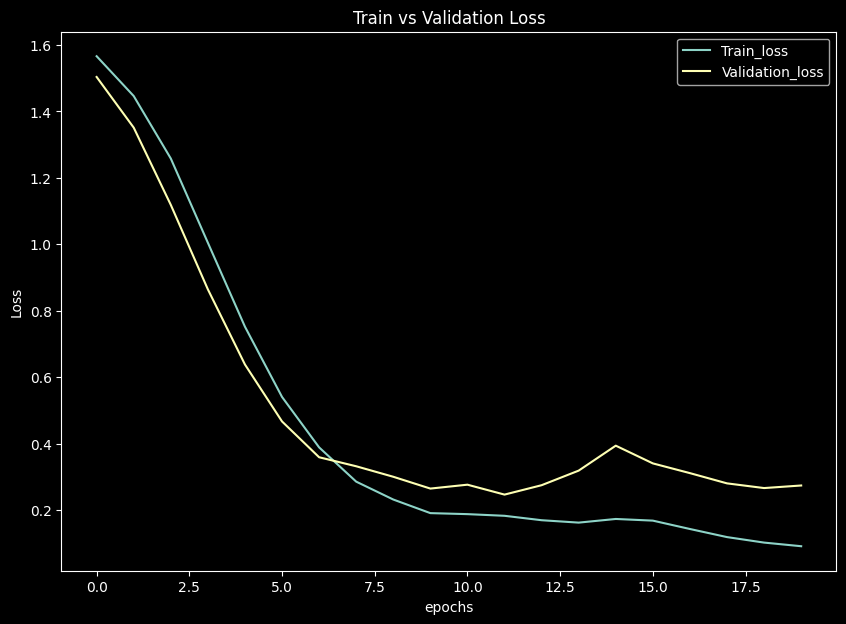

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["loss"], label = "Train_loss")
plt.plot(history.history["val_loss"], label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

---
<font color=green>Q17:</font>
<br><font color='green'>
Plot the training and validation accuracy
</font>

---

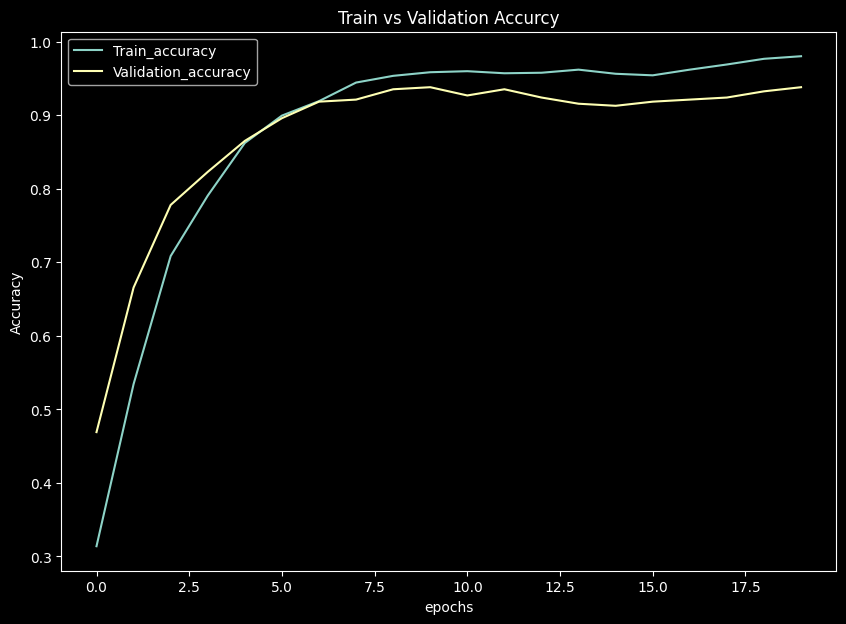

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["accuracy"], label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

---
<font color=green>Q18:</font>
<br><font color='green'>
Plot the training and validation precision
</font>

---

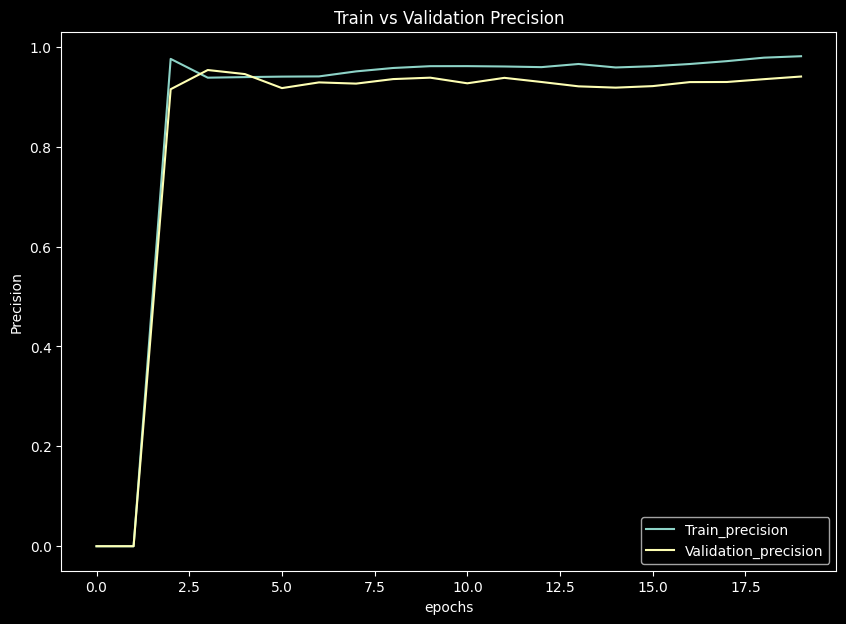

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["precision"], label = "Train_precision")
plt.plot(history.history["val_precision"], label = "Validation_precision")
plt.xlabel("epochs")
plt.ylabel("Precision")
plt.title("Train vs Validation Precision")
plt.legend()
plt.show()

---
<font color=green>Q19:</font>
<br><font color='green'>
Plot the training and validation recall
</font>

---

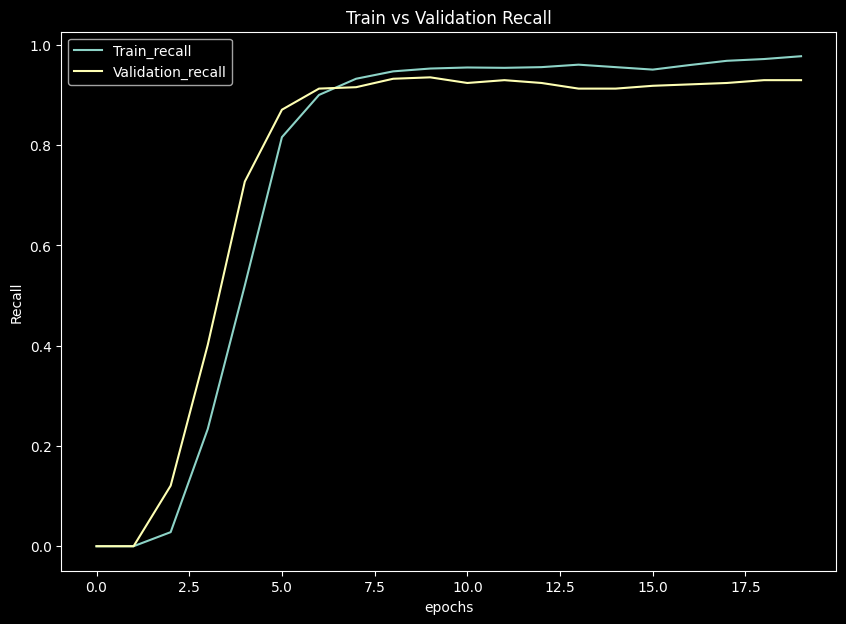

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["recall"], label = "Train_recall")
plt.plot(history.history["val_recall"], label = "Validation_recall")
plt.xlabel("epochs")
plt.ylabel("Recall")
plt.title("Train vs Validation Recall")
plt.legend()
plt.show()

---
<font color=green>Q20:</font>
<br><font color='green'>
Plot the confusion matrix using the function below
</font>

---

In [ ]:
# Import Modules
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Functin to plot the confusion matrix
def plot_confusion_matrix(y_test, y_hat):
  fig = plt.figure(figsize=(10, 8))
  g = sns.heatmap(confusion_matrix(y_test, y_hat),
              annot=True,
              fmt="0.0f")
  g.set_xlabel("Predicted")
  g.set_ylabel("Actual")
  g.set_title("Confusion Matrix on the test set")
  plt.show()

14/14 [==============================] - 5s 120ms/step


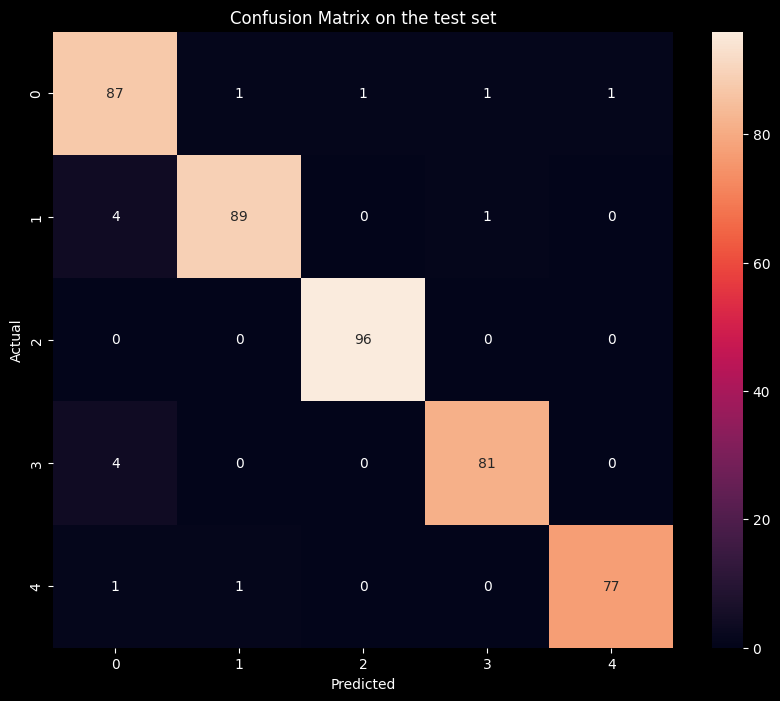

In [ ]:
# Get the prediction in the (N, K) shape
prediction = model.predict(test_data)

# Transform it into the shape (N,)
y_pred = np.argmax(prediction, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)


## 3.2 Training the embedding matrix

---
<font color=green>Q20:</font>
<br><font color='green'>
Create the following model :
</font>

---

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1FXc2jWEuuodqtu68Qeac33_V6J-mE__n"></center>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

# Set hyperparameters
d_1 = 32 # output dimension of the first LSTM layer
d_2 = 32 # output dimension of the second LSTM layer
K = 5 # Output dimension of the last layer


model = Sequential()
model.add(Embedding(V, D, input_length=T))
model.add(Bidirectional(LSTM(d_1, return_sequences = False)))
model.add(Dense(K, activation = "softmax"))
model.summary(line_length=150)

Model: "sequential"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 embedding (Embedding)                                             (None, 300, 200)                                            2000000                
                                                                                                                                                      
 bidirectional (Bidirectional)                                     (None, 64)                                                  59648                  
                                                                                                                                                      
 dense (Dense)                                                     (None, 

---
<font color=green>Q21:</font>
<br><font color='green'>
Fit your new model to the training data. Plot the tranining and validation loss,accuracy, precision and recall. Then, evaluate your model on the test data
</font>

---

In [ ]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

history = model.fit(train_data,
                    train_labels,
                    epochs = 200,
                    batch_size=256,
                    callbacks = callbacks_list,
                    validation_split=.2)

Epoch 1/200
6/6 [==============================] - 25s 4s/step - loss: 1.5971 - accuracy: 0.2619 - precision: 0.9684 - recall: 0.2295 - val_loss: 1.5738 - val_accuracy: 0.2612 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 11s 2s/step - loss: 1.5574 - accuracy: 0.2992 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5523 - val_accuracy: 0.2640 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 12s 2s/step - loss: 1.5085 - accuracy: 0.4228 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5106 - val_accuracy: 0.4831 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 13s 2s/step - loss: 1.4159 - accuracy: 0.5772 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4210 - val_accuracy: 0.5281 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 5/

In [ ]:
# Evaluate the model
model.evaluate(test_data, test_labels)

14/14 [==============================] - 1s 64ms/step - loss: 0.2122 - accuracy: 0.9506 - precision: 0.9548 - recall: 0.9483


[0.2121778279542923,
 0.9505618214607239,
 0.9547511339187622,
 0.9483146071434021]

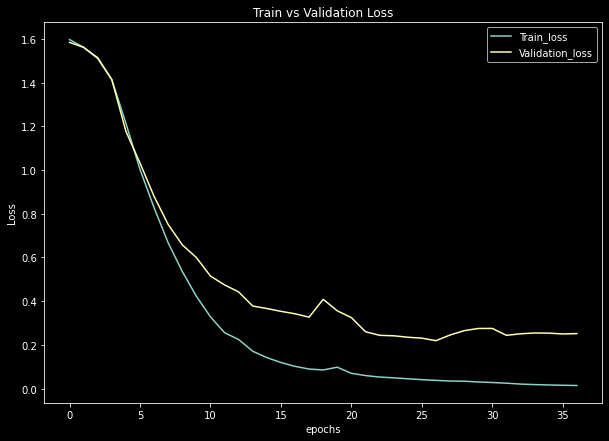

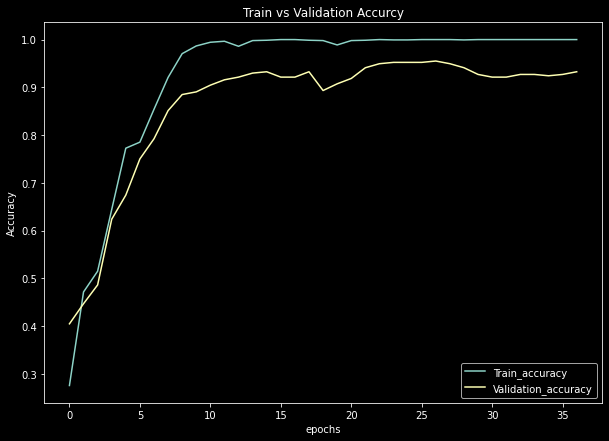

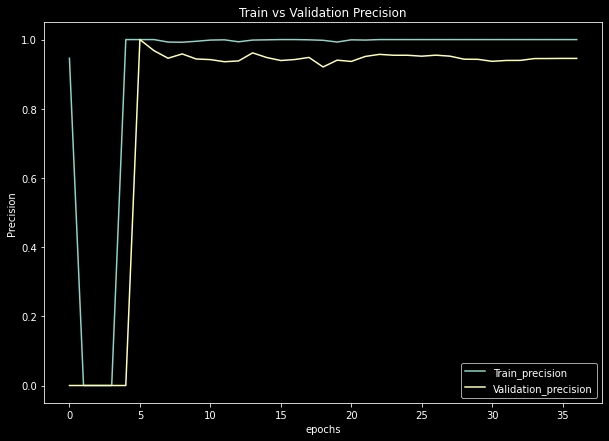

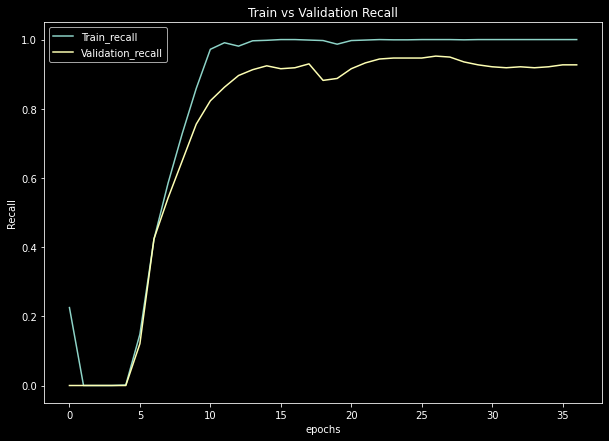

---
<font color=green>Q21:</font>
<br><font color='green'>
Plot the confusion matrix
</font>

---

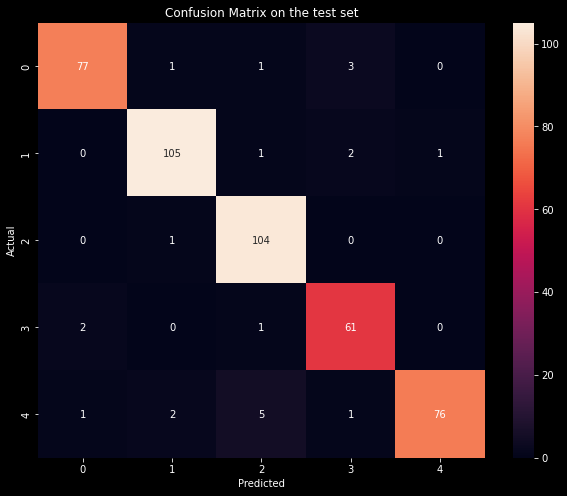

In [ ]:
# Get the prediction in the (N, K) shape


# Wrap-up

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1UZuzjojifkjy8BaLXejXYwGCjzL4DJua"></center>

## To go further...

As an exercise:

* Change the hyperparameters and add some regularization to have the same performance on the training dataset and the test dataset.

* Test different architectures on another dataset, stored in the folder "data": `news_headlines.csv`. This dataset contains the sentiments for financial news headlines from the perspective of a retail investor. Further details about the dataset can be found in: [Malo, P., Sinha, A., Takala, P., Korhonen, P. and Wallenius, J. (2014): “Good debt or bad debt: Detecting semantic orientations in economic texts.](https://arxiv.org/pdf/1307.5336.pdf)

## Introducing the next lecture

LSTM layers can be used to tackle a wide range of problems:

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1lB5wkfX66shxrymtQNfszXdKO8qjSD6h"></center>

For Many to many problems when the length of the input sequence is different from the length of the output sequence, we use the following architecture decribed in the following paper: [Sequence to Sequence Learning
with Neural Networks](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf):

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1SASHthGKMVBvlU0CcXX5Rfg0WYny4fS2"></center>

As seq2seq architecture don't handle very well long sentences, we use **Attention**, which aims at looking on a context in the input and weight it correctly to generate the output.

A good reference for it : [Attention Is All You Need](https://arxiv.org/pdf/1706.03762v5.pdf)

An example of application in Speech Recognition:

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1QkTzmlvA2OVVwnM0x91bVDd7CeVH7PlL"></center>: